In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import tensorflow
from keras import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model

import sklearn
from sklearn.model_selection import train_test_split

c:\Users\User\anaconda3\envs\env_pola\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
data_url = "https://drive.google.com/file/d/1Mr1niApw73MvOrXq3SA8hqoxt90jf0lV/view?usp=sharing"
data_url = 'https://drive.google.com/uc?id=' + data_url.split('/')[-2]
names_df = pd.read_csv(data_url)
names_df.columns = ["Name", "Gender"]

In [3]:
names_df.info()
names_df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12949 entries, 0 to 12948
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Name    12949 non-null  object
 1   Gender  12949 non-null  object
dtypes: object(2)
memory usage: 202.5+ KB


,Name,Gender
0,DAVIANDRIE ANDIKA BAHROENY,Laki-Laki
1,ELAN KURNIAWAN,Laki-Laki
2,AYU DWI CAHYANING MUKTI,Perempuan
3,WAHYOEDIN,Laki-Laki
4,NURHAENI,Perempuan


In [4]:
def preprocess(names_df, train=True):
    # Step 1: Lowercase the names
    names_df['Name'] = names_df['Name'].str.lower()

    # Step 2: Split The names to individual characters
    names_df['Name'] = [list(name) for name in names_df['Name']]

    # Step 3: Pad names with spaces to make all names same length
    name_length = 50
    names_df['Name'] = [
        (name + [' ']*name_length)[:name_length] 
        for name in names_df['Name']
    ]

    # Step 4: Encode Names to Array of Numbers
    names_df['Name'] = [
        [
            max(0.0, ord(char)-96.0) 
            for char in name
        ]
        for name in names_df['Name']
    ]
    
    if train:
        # Step 5: Encode Gender to Numbers
        names_df['Gender'] = [
            0.0 if gender=='Perempuan' else 1.0 
            for gender in names_df['Gender']
        ]
    
    return names_df

names_df = preprocess(names_df)
names_df.head()

,Name,Gender
0,"[4.0, 1.0, 22.0, 9.0, 1.0, 14.0, 4.0, 18.0, 9....",1.0
1,"[5.0, 12.0, 1.0, 14.0, 0.0, 11.0, 21.0, 18.0, ...",1.0
2,"[1.0, 25.0, 21.0, 0.0, 4.0, 23.0, 9.0, 0.0, 3....",0.0
3,"[23.0, 1.0, 8.0, 25.0, 15.0, 5.0, 4.0, 9.0, 14...",1.0
4,"[14.0, 21.0, 18.0, 8.0, 1.0, 5.0, 14.0, 9.0, 0...",0.0


In [5]:
def lstm_model(num_alphabets=27, name_length=50, embedding_dim=256):
    model = Sequential([
        Embedding(num_alphabets, embedding_dim, input_length=name_length),
        Bidirectional(LSTM(units=128, recurrent_dropout=0.2, dropout=0.2)),
        Dense(1, activation="sigmoid")
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

In [6]:
# Step 1: Instantiate the model
model = lstm_model(num_alphabets=27, name_length=50, embedding_dim=256)

In [7]:
# Step 2: Split Training and Test Data
X = np.asarray(names_df['Name'].values.tolist())
y = np.asarray(names_df['Gender'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0)


In [8]:
# Step 3: Train the model
callbacks = [
    EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-3,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1),
]

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=64,
                    epochs=5,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks)


Epoch 1/5
162/162 [==============================] - 210s 1s/step - loss: 0.5093 - accuracy: 0.7490 - val_loss: 0.4111 - val_accuracy: 0.8151
Epoch 2/5
162/162 [==============================] - 137s 844ms/step - loss: 0.3946 - accuracy: 0.8225 - val_loss: 0.3453 - val_accuracy: 0.8517
Epoch 3/5
162/162 [==============================] - 174s 1s/step - loss: 0.3213 - accuracy: 0.8654 - val_loss: 0.2862 - val_accuracy: 0.8842
Epoch 4/5
162/162 [==============================] - 121s 747ms/step - loss: 0.2751 - accuracy: 0.8875 - val_loss: 0.2604 - val_accuracy: 0.8961
Epoch 5/5
162/162 [==============================] - 94s 580ms/step - loss: 0.2468 - accuracy: 0.8984 - val_loss: 0.2419 - val_accuracy: 0.9027


In [9]:
# Step 4: Save the model
model.save('gender_prediction.h5')

In [10]:
# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Accuracy:', accuracy)

81/81 [==============================] - 13s 162ms/step - loss: 0.2419 - accuracy: 0.9027
Accuracy: 0.9027026891708374


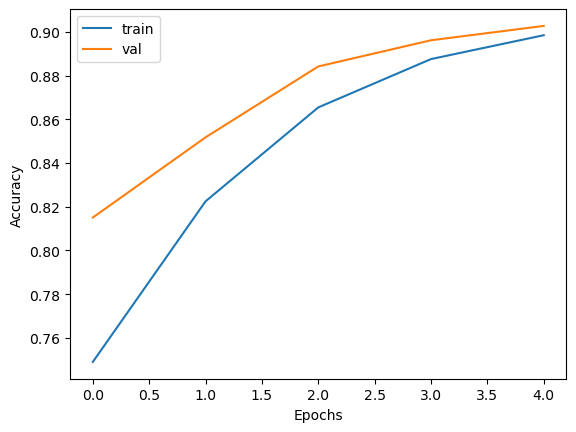

In [11]:
# Step 6: Plot accuracies
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Testing: Predictions

In [12]:
#Load the model
pred_model = load_model('gender_prediction.h5')

In [16]:
# Input names
names = ['Eka']

# Convert to dataframe
pred_df = pd.DataFrame({'Name': names})

# Preprocess
pred_df = preprocess(pred_df, train=False)

# Predictions
result = pred_model.predict(np.asarray(
    pred_df['Name'].values.tolist())).squeeze(axis=1)

pred_df['Pria atau Wanita?'] = [
    'Pria' if logit > 0.5 else 'Wanita' for logit in result
]

pred_df['Probability'] = [
    logit if logit > 0.5 else 1.0 - logit for logit in result
]

# Format the output
pred_df['Name'] = names
#pred_df.rename(columns={'Name': 'Name'}, inplace=True)
pred_df['Probability'] = pred_df['Probability'].round(2)
pred_df.drop_duplicates(inplace=True)

pred_df.head()

1/1 [==============================] - 0s 98ms/step


,Name,Pria atau Wanita?,Probability
0,Eka,Wanita,0.64
